# One Max Problem

##### One Max Problem — DEAP 1.3.1 documentation. (2020). Retrieved 11 August 2020, from https://deap.readthedocs.io/en/master/examples/ga_onemax.html

Utilizaremos la librería de Python DEAP que es un framework de cómputo evolutivo para hacer prototipos rápidamente y probar ideas. Busca hacer algoritmos explícitos y estructuras de datos transparentes. Trabaja en perfecta armonía con mecanismos de paralelismo como `multiprocessing` y `SCOOP`.

## Ejemplo que maximiza la suma de una lista de enteros.

Por ejemplo se comienza con un conjunto de listas de 0s y 1s aleatorios (e.g. [0,1,0,0,0]), y se busca evolucionar hasta que algún elemento llegue a ser de la forma [1,1,1,1,1].

Hay muchos parámetros que se pueden ajustar como la logitud de las listas, el tamaño inicial de la población, etc.

El problema a resolver ayuda a entender algunas de las posibilidades de este framework e ilustra de manera concisa el concepto de máquinas evolutivas en general. Primero importaremos los módulos necesarios



In [1]:
import random

from deap import base
from deap import creator
from deap import tools

## Creator 

Debido a que la estructura exacta de los individuos en los algoritmos genéticos depende fuertemente en la problema que se quiere resolver, DEAP no tiene una estructura explícita. Lo que si hace es darnos una manera conveniente para crear "contenedores" de atributos, asociarlos con su aptitud (fitness) llamado $\texttt{deap.creator}$. 

$\texttt{creator}$ es una fábrica de clases que las va generando durante el tiempo de ejecución. El primer argumento es el nombre de la clase, seguido de la clase base de la cual heredará, y finalmente cualquier argumento que queramos pasar a la hora de instanciar la misma.

In [2]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

## Toolbox

Utilizaremos la clase a la medida que acamos de crear y haremos uso de Toolbox para crear a nuestro individuos así como a toda la población.

Herramientas para crear a los individuos ($\texttt{random.randint}$), los individuos mismos y la población, quedará registarada bajo un contenedor llamado $\texttt{Toolbox}$. Tiene dos métodos para agregar o remover contenido, register() y unregister().

Es importante mencionar que de forma análoga a $\texttt{creator.create}$, el primer argumento es el nombre de nuestra función, luego la función que encapsula y finalmente los argumentos de la función. Al registrar las herramientas en el toolbox, solamente crea alias a la funciones ya existentes y congela parte de sus argumentos. Con esto podemos dejar algunos de los argumentos abiertos para modificarlos después. Por ejemplo, en el caso de la población.

In [3]:
toolbox = base.Toolbox()

# Generador de atributos 
#                      'attr_bool' es un atributo ('gen')
#                      que corresponde a enteros uniformemente muestreados
#                      del rango [0,1] (i.e. 0 o 1 con igual
#                      probabilidad)
toolbox.register("attr_bool", random.randint, 0, 1)

# Inicializador de estructura
#                         define 'individuo' como uno consistiendo 
#                         de 50 elementos 'attr_bool' ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 50)

# Define la población como un conjunto de individuos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# La funcion objetivo ('fitness') a maximizar
def evalOneMax(individual):
    return sum(individual),

#----------
# Registro de operaciones
#----------
# Registra el objetivo / fitness
toolbox.register("evaluate", evalOneMax)

# Registra el operador de cruza
toolbox.register("mate", tools.cxTwoPoint)

# Registra el operador de mutación que cambia cada
# atributo/gen con probabilidad of 0.0555
toolbox.register("mutate", tools.mutFlipBit, indpb=0.0555)

# operador para seleccionar individuos por el método de la ruleta
# donde cada elemento de la nueva generación se sustituye por 
# otro de la población total. La probabilidad de obtener un 1
# está dada por la suma de todos los 1s entre el total. 
# Evidentemente lo mismo para el 0. 
toolbox.register("select", tools.selTournament,fit_attr='fitness',tournsize=3)

#----------


## Evolucionando la población

Una vez que se eligen los operadores genéticos, vamos a definir un algoritmo que combine todas las partes individuales y que realice la evolución de nuestra población hasta que el problema de maximización de un parámetro se resuelva. Por convención, esto se hará dentro de una función llamada $\texttt{main()}$.

In [4]:
import logging
import timeit
# Cambia logging.INFO para obtener menos verborrea
# Cambia logging.WARNING para silenciar por completo
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
def main(
    poblacion_inicial: int = 50,
    tamaño_individuo: int = 30,
    prob_cruza: float = 0.7,
    prob_mutación: float = 0.0555,
    max_iter: int = 1000,
):
    random.seed()

    # Decidí registrar al individuo y a la población aquí
    # para poder invocar la función main con todos los
    # argumentos sin tener que ir más arriba a redefinir valores
    toolbox.register(
        "individual",
        tools.initRepeat,
        creator.Individual,
        toolbox.attr_bool,
        tamaño_individuo,
    )

    # Se define la población como un conjunto de n=poblacion_inicial listas
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # Crea una población inicial de n individuos
    # (cada uno es una lista de 0s y 1s)
    pop = toolbox.population(n=poblacion_inicial)

    # CXPB  es la probabilidad de cruza
    #
    #
    # MUTPB es la probabilidad de mutación
    CXPB, MUTPB = prob_cruza, prob_mutación

    logging.debug("Start of evolution")

    # Se evalua la aptitud (fitness) de la población entera 
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    logging.debug("  Evaluated %i individuals" % len(pop))

    # Se extrae la aptitud (fitness)
    fits = [ind.fitness.values[0] for ind in pop]

    # Esta variable guarda el número de generaciones    
    g = 0

    # Comienza la evolución
    while max(fits) < tamaño_individuo and g < max_iter:
        # Una nueva generación
        g = g + 1
        logging.debug("-- Generation %i --" % g)

        # Selecciona la nueva generación de individuos
        offspring = toolbox.select(pop, len(pop))
        # Clona los individuos seleccionados
        offspring = list(map(toolbox.clone, offspring))

        # Aplica la cruza y mutación
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cruza a dos individuos con probabilidad CXPB
            if random.random() < CXPB:
                toolbox.mate(child1, child2)

                # aptitudes de los hijos
                # deben ser recalculados
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # muta con probabilidad MUTPB
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evalua a los individuos con una aptitud inválida
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        logging.debug("  Evaluated %i individuals" % len(invalid_ind))

        # La población es reemplazada por los hijos
        pop[:] = offspring

        # Junta todas las aptitudes en una lista e imprime estadísticas
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x * x for x in fits)
        std = abs(sum2 / length - mean ** 2) ** 0.5

        logging.debug("  Min %s" % min(fits))
        logging.debug("  Max %s" % max(fits))
        logging.debug("  Avg %s" % mean)
        logging.debug("  Std %s" % std)

    logging.debug("-- Fin de la evolución actual--")

    best_ind = tools.selBest(pop, 1)[0]
    logging.info("Número de generaciones %s" % g)
    logging.info("El mejor individuo es %s, %s" % (best_ind, best_ind.fitness.values))
    return g


if __name__ == "__main__":
    main()


# Aleatoridad y tiempo de cómputo - Torneo
 
A continuación veremos como el número de generaciones es proporcional al tiempo de cómputo. El resultado es bastante intuitivo, entre más generaciones tardamos en llegar a la lista de 1s, mayor es el tiempo de procesamiento

In [5]:
# Funcion para almacenar el número de generaciones y el tiempo de ejecución
import io
from contextlib import redirect_stdout


def generaciones_y_tiempo(
    poblacion_inicial: int = 50,
    tamaño_individuo: int = 30,
    prob_cruza: float = 0.7,
    prob_mutación: float = 0.0555,
    max_iter: int =1000):
    f = io.StringIO()
    with redirect_stdout(f):
        print(
            timeit.timeit(
                f"print(main(poblacion_inicial={poblacion_inicial} ,tamaño_individuo={tamaño_individuo} ,prob_cruza={prob_cruza},prob_mutación={prob_mutación},max_iter={max_iter}))",
                number=1,
                globals=globals(),
            )
        )
    out = f.getvalue()
    return list(out.split("\n")[:-1])


In [6]:
datos_tarea=[generaciones_y_tiempo() for i in range(100)]

In [7]:
import pandas as pd
def limpiar_dataframe(datos:list):
    df = pd.DataFrame(datos)
    df.rename(columns={0:"Generations",1:"Compute_time"},inplace=True)
    df=df.sort_values(by="Compute_time")
    df=df.reset_index(drop=True)
    df=df.astype({"Compute_time":float, "Generations":int})
    return df
df=limpiar_dataframe(datos_tarea)
df.head()

,Generations,Compute_time
0,8,0.019555
1,9,0.020255
2,9,0.020447
3,10,0.022317
4,10,0.022483


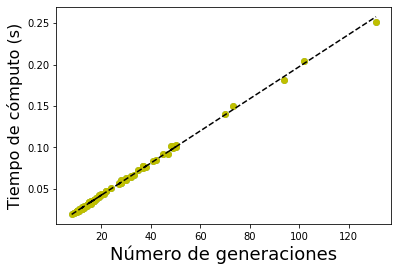

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def graficar_df(df:pd.DataFrame):
    x = df["Generations"]
    y = df["Compute_time"]

    plt.scatter(x, y, alpha=0.5)
    plt.xlabel('Número de generaciones', fontsize=18)
    plt.ylabel('Tiempo de cómputo (s)', fontsize=16)


    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y

    plt.plot(x,y,'yo',x,poly1d_fn(x),'--k')
graficar_df(df)

# Veamos como cambia el tiempo de cómputo al incrementar la probabilidad de mutación

In [9]:
datos_mutacion_alta=[generaciones_y_tiempo(prob_mutación=0.3,max_iter=4000) for i in range(100)]


In [10]:
df2=limpiar_dataframe(datos_mutacion_alta)
df2.head()

,Generations,Compute_time
0,8,0.018563
1,8,0.018848
2,8,0.019049
3,8,0.019698
4,8,0.020264


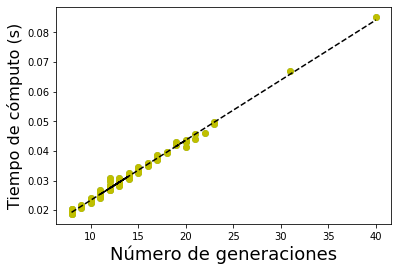

In [11]:
graficar_df(df2)

# Veamos como cambia el tiempo de cómputo al incrementar la probabilidad de cruza

In [12]:
datos=[generaciones_y_tiempo(prob_cruza=1,max_iter=4000) for i in range(100)]
df3=limpiar_dataframe(datos)
df3.head()

,Generations,Compute_time
0,6,0.016008
1,6,0.016304
2,7,0.018242
3,7,0.018388
4,8,0.019592


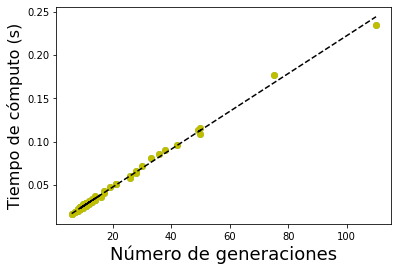

In [13]:
graficar_df(df3)

# En general es interesante ver como los parámetros afectan de distinta manera el tiempo de cómputo, o el número de generaciones que se necesita para llegar a una solución

In [14]:
toolbox.register("select", tools.selRoulette,fit_attr='fitness')

# Aleatoridad y tiempo de cómputo - Ruleta
A continuación veremos como el número de generaciones es proporcional al tiempo de cómputo. El resultado es bastante intuitivo, entre más generaciones tardamos en llegar a la lista de 1s, mayor es el tiempo de procesamiento


In [15]:
# Funcion para almacenar el número de generaciones y el tiempo de ejecución
import io
from contextlib import redirect_stdout


def generaciones_y_tiempo(
    poblacion_inicial: int = 50,
    tamaño_individuo: int = 30,
    prob_cruza: float = 0.7,
    prob_mutación: float = 0.0555,
    max_iter: int =1000):
    f = io.StringIO()
    with redirect_stdout(f):
        print(
            timeit.timeit(
                f"print(main(poblacion_inicial={poblacion_inicial} ,tamaño_individuo={tamaño_individuo} ,prob_cruza={prob_cruza},prob_mutación={prob_mutación},max_iter={max_iter}))",
                number=1,
                globals=globals(),
            )
        )
    out = f.getvalue()
    return list(out.split("\n")[:-1])


In [16]:
datos_tarea=[generaciones_y_tiempo() for i in range(100)]

In [17]:
import pandas as pd
def limpiar_dataframe(datos:list):
    df = pd.DataFrame(datos)
    df.rename(columns={0:"Generations",1:"Compute_time"},inplace=True)
    df=df.sort_values(by="Compute_time")
    df=df.reset_index(drop=True)
    df=df.astype({"Compute_time":float, "Generations":int})
    return df
df=limpiar_dataframe(datos_tarea)
df.head()

,Generations,Compute_time
0,43,0.167408
1,48,0.178559
2,57,0.201320
3,55,0.210100
4,52,0.214055


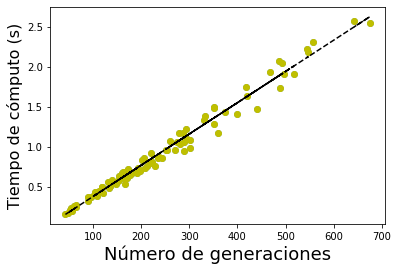

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def graficar_df(df:pd.DataFrame):
    x = df["Generations"]
    y = df["Compute_time"]

    plt.scatter(x, y, alpha=0.5)
    plt.xlabel('Número de generaciones', fontsize=18)
    plt.ylabel('Tiempo de cómputo (s)', fontsize=16)


    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y

    plt.plot(x,y,'yo',x,poly1d_fn(x),'--k')
graficar_df(df)

# Veamos como cambia el tiempo de cómputo al incrementar la probabilidad de mutación

In [19]:
datos_mutacion_alta=[generaciones_y_tiempo(prob_mutación=0.3,max_iter=4000) for i in range(100)]


In [20]:
df2=limpiar_dataframe(datos_mutacion_alta)
df2.head()

,Generations,Compute_time
0,36,0.125837
1,52,0.195224
2,97,0.349806
3,110,0.380951
4,107,0.391929


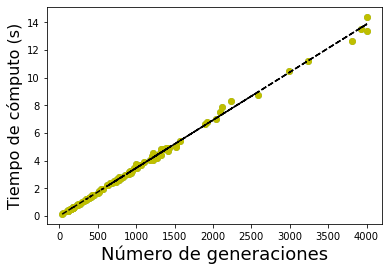

In [21]:
graficar_df(df2)

# Veamos como cambia el tiempo de cómputo al incrementar la probabilidad de cruza

In [22]:
datos=[generaciones_y_tiempo(prob_cruza=1,max_iter=4000) for i in range(100)]
df3=limpiar_dataframe(datos)
df3.head()

,Generations,Compute_time
0,30,0.087127
1,30,0.093777
2,34,0.101599
3,35,0.112305
4,40,0.118224


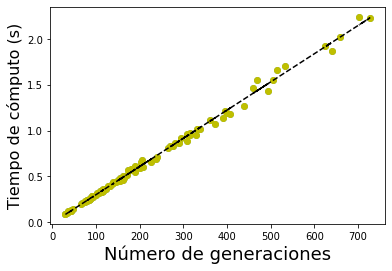

In [23]:
graficar_df(df3)